In [ ]:
#!pip install catboost

Import all necessary libraries

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import pickle
import pandas as pd
from sklearn.impute import KNNImputer


Import datatset

In [ ]:
df = pd.read_csv(".\datasets\healthcare-dataset-stroke-data.csv")


Preprocess our dataset

In [3]:
df_model = df[[
    'gender', 'age', 'hypertension', 'heart_disease',
    'avg_glucose_level', 'bmi', 'smoking_status', 'stroke'
]].copy()

# Map gender to binary: Male = 1, Female = 0
df_model['gender'] = df_model['gender'].map({'Male': 1, 'Female': 0, 'Other': 0})

# Drop rows with missing gender (if any) after mapping
df_model.dropna(subset=['gender'], inplace=True)

# Define features and target
X = df_model.drop(columns='stroke')
y = df_model['stroke']

# Define preprocessing pipeline
numeric_features = ['age', 'avg_glucose_level', 'bmi']
numeric_transformer = KNNImputer(n_neighbors=5)

categorical_features = ['smoking_status']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'  # gender, hypertension, heart_disease
)

In [4]:
# Fit the preprocessor on the training data
preprocessor.fit(X)

# Transform the training and testing data
X = preprocessor.transform(X)


Balance the classes (initially 96% of 0 vs only 4% of 1 )

In [5]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X,y)

Split the data

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [7]:
y_train.value_counts()

,count
stroke,
1,3891
0,3886


Choose between most 2 of the most adapted models for medical use Logistic Regression and CatBoost 

In [10]:
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
models = {
    'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'CatBoost' : CatBoostClassifier(iterations=500, learning_rate=0.05, depth=6,eval_metric='F1', verbose=0, random_state=42)
}


In [12]:
best_f1 = 0
best_model_name = None
best_pipeline = None

for name, clf in models.items():
    print(f"Training {name}...")
    pipeline = Pipeline(steps=[
        ('classifier', clf)
    ])
    pipeline.fit(X_train, y_train)

    # Predict on the original, processed test set
    y_pred = pipeline.predict(X_test)

    print(f"\nClassification Report for {name}:")
    report = classification_report(y_test, y_pred, digits=3, output_dict=True)
    print(classification_report(y_test, y_pred, digits=3))

    if report['1']['f1-score'] > best_f1:
        best_f1 = report['1']['f1-score']
        best_model_name = name
        best_pipeline = pipeline

Training LogisticRegression...

Classification Report for LogisticRegression:
              precision    recall  f1-score   support

           0      0.799     0.742     0.769       975
           1      0.758     0.812     0.784       970

    accuracy                          0.777      1945
   macro avg      0.778     0.777     0.777      1945
weighted avg      0.778     0.777     0.777      1945

Training CatBoost...

Classification Report for CatBoost:
              precision    recall  f1-score   support

           0      0.945     0.983     0.963       975
           1      0.982     0.942     0.962       970

    accuracy                          0.962      1945
   macro avg      0.963     0.962     0.962      1945
weighted avg      0.963     0.962     0.962      1945



CatBoost is by far more accurate

In [13]:
best_model_name

'CatBoost'

The learning curve plot indicates that our model has good generalization, is not suffering from high bias

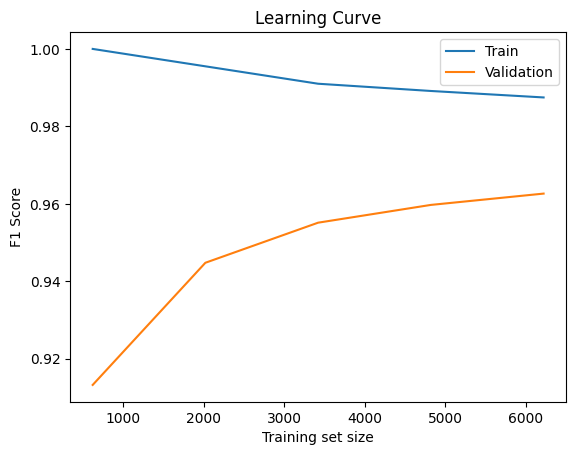

In [14]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    best_pipeline, X_train, y_train,
    cv=5, scoring="f1", n_jobs=-1
)

plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Train")
plt.plot(train_sizes, np.mean(test_scores, axis=1), label="Validation")
plt.legend()
plt.xlabel("Training set size")
plt.ylabel("F1 Score")
plt.title("Learning Curve")
plt.show()

In [15]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(best_pipeline, X_train, y_train, cv=5, scoring="f1")
print("Cross-validation F1 scores:", scores)
print("Mean:", scores.mean(), "Std:", scores.std())

Cross-validation F1 scores: [0.96       0.96349413 0.96349413 0.96416938 0.96596859]
Mean: 0.9634252466932486 Std: 0.0019372206058504364


Save the model for future use

In [16]:
with open('tr_model_best.sav', 'wb') as f:
        pickle.dump(best_pipeline, f)